In [0]:
#import for qiskit
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization import plot_bloch_multivector
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
backend = Aer.get_backend('qasm_simulator') 

#some useful import
import cmath as math
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

%matplotlib inline

#import for printing
from IPython.display import display, Markdown, Latex, HTML

#turn off warnings
import warnings
warnings.filterwarnings('ignore')

#some function for plot

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
    
def alpha(counts):
    if (len(counts) == 2):
        return counts['0']/ (counts['0'] + counts['1']) 
    elif (list(counts.keys())[0] == '0'): 
        return 1
    else:
        return 0

def Z(a):
    if (a == 0):
        return math.inf
    else:
        return abs(math.sqrt(1 - 1 / a))

def q_plot(IN, fsize = (9, 2)):    
    '''visualisation of qubits'''
    fig = plt.figure(figsize = fsize)

    for i in range(len(IN)):
        ax1 = fig.add_subplot(1, len(IN), i + 1)
        a = IN[i] 
        opacity = 1 
        
        ax1.plot([0, 0, 0.3, 0.3, 0], [0, 1, 1, 0, 0], 'k', linewidth = 2)
        ax1.fill([0, 0, 0.3, 0.3, 0], [1, a, a, 1, 1] , 'w')
        
        ax1.plot([0, 0.3], [a, a], 'k')
        ax1.fill([0, 0, 0.3, 0.3, 0], [0, a, a, 0, 0] , 'k', alpha = opacity)

        ax1.set_xlim(-0.0, 0.3)
        ax1.set_ylim(-0.0, 1.)
        z = np.round(Z(a), decimals = 3)
        ax1.set_title('|z|=' +  str(z))

        ax1.axis('off')

def theo_plot():
    z = [1, math.inf, -1.0, 0.0, 1.0]
    titles = ['z='+str(1), 'z='+'$\\infty$','z='+str(-1), 'z='+str(0), 'z='+str(1)]

    fig = plt.figure(figsize = (9, 2))

    for i in range(len(z)):
        ax1 = fig.add_subplot(1, len(z), i + 1)

        if (z[i] == 1j):
            a = 1
        else:
            a = (abs(z[i] / np.sqrt(1 + abs(z[i])**2)))**2

        opacity = (np.pi + np.angle(z[i])) / (2 * np.pi)

        ax1.plot([0, 0, 0.3, 0.3, 0], [0, 1, 1, 0, 0], 'k', linewidth = 2)
        ax1.fill([0, 0, 0.3, 0.3, 0], [1, a, a, 1, 1] , 'w')

        ax1.plot([0, 0.3], [a, a], 'k')
        ax1.fill([0, 0, 0.3, 0.3, 0], [0, a, a, 0, 0] , 'k', alpha = opacity)

        ax1.set_title(titles[i])
        ax1.set_xlim(-0.0, 0.3)
        ax1.set_ylim(-0.0, 1.)
        ax1.axis('off')

You must install the qiskit module if you get the error message: ModuleNotFoundError: No module named 'qiskit', for solving this error run the next cell.

In [0]:
pip install qiskit

In [0]:
class QCIRCUIT:
    '''
    The QCIRCUIT is a class based on qiskit, using for creating circuits for the realization of iterated nonlinear protocols.
    Created by me, Portik Attila.
                                                                                                                            '''
    
    def __init__(self, n, m = 1, d = 3):
        '''Initializing the class from input parameters.
            Parameters:
            | name  |   type   |         describe of parameter      | default value |
            -------------------------------------------------------------------------
            |   n   |  integer |    number of qubits in system      |     -----     |        
            |   m   |  integer | number of classical bits in system |       1       |
            |   d   |  integer |    degree of iterated function     |       3       |
                                                                                        '''
        #add internal variable to class
        self._n = n
        self._d = d
        self._initial_state = [0, 0, 0] # <- intial state of qubits
        self._parameters = [0, 0, 0] # <- parameters of used unitary transformation
        self._start_bit = 0 # <- variables for calculating
        self._end_bit = n - 1
        self._number_of_used_bits = 0
        #create a circuit with n qubits and m classical bit
        self._circuit = QuantumCircuit(n, m)

    def information(self):
        display(Latex('$$ n_{max} = \left \lceil \dfrac{m}{d - 1} \\right \\rceil-1 =' 
                      + str(int(np.ceil(self._n / (self._d - 1)) -1)) + '$$'))
        print('Parameters of U transformation')
        display(Latex('''$$\mathbf{U}_3 =  
                    \begin{pmatrix}
                    \cos\left(\frac{x}{2}\right)& e^{iy}\sin\left(\frac{x}{2}\right) \\
                    e^{iz}\sin\left(\frac{x}{2}\right) & e^{i z + i y}\cos\left(\frac{x}{2}\right)\\
                    \end{pmatrix}$$'''))
    
    def cell_plot(self):
        ''' Plotting a part from the circuit, which realizes a single iteration. 
                                                                                '''
        qc = QuantumCircuit(self._d, 1) #<- simple circuit
        qc.u3(0, 0, 0, range(self._d)) #<- settin initialstate
        qc.cx((self._d - 1) * np.ones(self._d -1, dtype = int), range(self._d - 1)) #<- necessary CNOT gates
        qc.barrier(range(self._d)) #<- barrier for separation
        qc.swap(0, self._d - 1) #<- move the selected qubits to the first free qubits
        qc.u3(0, 0, 0, 0) #<- using three-parameter unitary transformation for generality
        qc.measure(0,0) #adding a measure to the selected qubits
        display(qc.draw(output = 'mpl')) #plotting the circuit


    def number_of_iteration(self, n):
        '''Setting the number of iterations.
         Parameters:
         | name  |   type   |         describe of parameter      | default value |
         -------------------------------------------------------------------------
         |   n   |  integer |         number of iterations       |     -----     |

                                          '''
        if (n > int(np.ceil(self._n / (self._d - 1)))): #<- checking that can implement the iteration on this system
            print('ERROR: The number of iteration is more than the maximum number of iteration on this system.')
            n = int(np.ceil(self._n / (self._d - 1))) #<- changing the value of iteration to maximum the maximum of the value
        #setting internal variabels
        self._number_of_iteration = n
        self._requisite_bits = (n + 1) * (self._d - 1) - 1
        self._end_bit = self._requisite_bits -1
        
    def initial_state(self, x, y, z):
        '''Setting the initial state of the qubits. 
           For the settings of the initial state, we applied a transformation to zero state(|0> + 0*|1>). 
         Parameters:
         | name  |   type   |         describe of parameter      | default value |
         -------------------------------------------------------------------------
         |   x   |  double  |          1st parameter of U3       |     -----     |
         |   y   |  double  |          2nd parameter of U3       |     -----     |
         |   z   |  double  |          3rd parameter of U3       |     -----     |

         Note: For more information from parameter, use the '.information()' function of QCIRCUIT class.         
                                                                                                       '''

        self._initial_state = [x, y, z]
    
    def parameters(self, x, y, z):
        '''Setting the parameters of applied unitary transformation.
        Parameters:
         | name  |   type   |         describe of parameter      | default value |
         -------------------------------------------------------------------------
         |   x   |  double  |          1st parameter of U3       |     -----     |
         |   y   |  double  |          2nd parameter of U3       |     -----     |
         |   z   |  double  |          3rd parameter of U3       |     -----     |

         Note: For more information from parameter, use the '.information()' method of QCIRCUIT class.         
                                                                                                       '''
        self._parameters = [x, y, z]
       
    def draw_circuit(self):
        '''Draw the circuit
                          '''
        display(self._circuit.draw(output = 'mpl'))
        
    def _set_initial_state(self):
        '''Internal function for setting the initial state.
                                                          '''

        #add u3 gate to bits for set the initial state of qubits
        self._circuit.u3(self._initial_state[0], self._initial_state[1], self._initial_state[2],
                        np.arange(self._requisite_bits))
        
    
    def _cell(self, bits):
        '''Internal function. Implementation of a basic part of the circuit. 
        It realizes an elementary step, one iteration on d qubits, where d is the degree of mapping. 
        Parameters:
         | name  |      type        |         describe of parameter      | default value |
         -------------------------------------------------------------------------
         |  bits | tuple, or array  |   list of indexes of input qubits  |     -----     |
                                                                                                   '''
        
        #add CNOT gate to bits
        self._circuit.cx((bits[-1]) * np.ones(self._d - 1, dtype = int), bits[:-1])
        
        #just a barrier
        self._circuit.barrier(bits)
        
        #swap the bits 
        self._circuit.swap(bits[-1], self._number_of_used_bits)
        self._number_of_used_bits += 1
        
        
    def _layer(self):
        ''''Internal function. Implementation of one layer in the circuit.  
        Every layer in the circuit makes one more iteration on all possible qubits.
                                                                                  '''
        
        while ((self._end_bit - self._number_of_used_bits) >= 2): # while loop for  constructing layer
            for i in np.arange(self._start_bit, self._end_bit, self._d):
                if (len(np.arange(i, self._end_bit + 1)) >= self._d):
                    self._cell(np.arange(i, i + self._d))
            self._circuit.barrier(np.arange(self._n))

            self._start_bit = self._number_of_used_bits
        
        self._circuit.u3(self._parameters[0], self._parameters[1], self._parameters[2], 
                        range(self._number_of_used_bits))
            
        self._number_of_used_bits = 0
        self._end_bit = self._end_bit - (self._d - 1)
    
    def build_iteration_circuit(self):
        ''' Function for build the circuit from layers.
                                                     '''
        self._set_initial_state() #<- setting intial sate
        for i in range(self._number_of_iteration): #<- for loop for constructing layers
            self._layer()
            self._circuit.barrier(range(self._n))


### Quantum circuit for iteration of function 
$$f_{d,p}(z) = \dfrac{p+z^d}{1-p^*z^d}$$

In [0]:
QC = QCIRCUIT(9) # system of 9 qubits

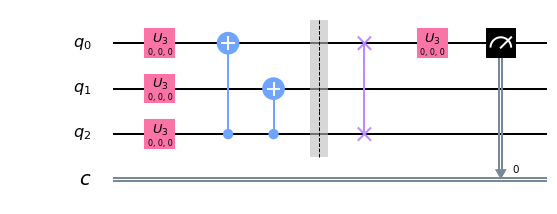

In [5]:
QC.cell_plot() # plot of circuit 

Maximum of number of iterations of function

$$ n_{max} = \left \lceil \dfrac{m}{d - 1} \right \rceil-1 $$
m - number of bits \\
d - degree of iterated function \\
EX: \\
$$
\begin{matrix}
m = 15 \\
d = 3 \\
\end{matrix}
\Rightarrow n_{max}= 7
$$

Matrix of $U_3$ gate
$$
\mathbf{U}_3 =  
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right)& e^{i\lambda}\sin\left(\frac{\theta}{2}\right) \\
 e^{i\varphi}\sin\left(\frac{\theta}{2}\right) & e^{i\varphi + i\lambda}\cos\left(\frac{\theta}{2}\right)\\
\end{pmatrix}
= N \cdot 
\begin{pmatrix}
1& p \\
-p^*& 1 \\
\end{pmatrix}
$$
$\Rightarrow p = - e^{i \lambda}\tan(\theta / 2) $

Matrix of CNOT gates
$$
   \mathbf{M} = 
    \begin{pmatrix}
    \mathbf{1}^{(n)} & \mathbf{0}^{(n)} \\
    \mathbf{0}^{(n)} & \mathbf{J}^{(n)} 
    \end{pmatrix}
$$

$\mathbf{1}^{(n)}$ - n dimensional identity matrix \\
$\mathbf{0}^{(n)}$ - n dimensional zero matrix \\
$\mathbf{J}^{(n)}$ - n dimensional antidiagonal all-ones matrix

$\rightarrow$ fourth iteration of $f_{3,1}(z)$ in $z = 1$ point.

Initial state is:
$$
N(z) \cdot \big(|0 \rangle + z \cdot |1 \rangle \big) = \dfrac{1}{\sqrt{2}} \cdot \big(|0 \rangle +  |1 \rangle \big) \Longleftrightarrow \mathbf{U}_3(\pi/2, 0, 0)\big(|0 \rangle +  0 \cdot |1 \rangle \big)
$$ 

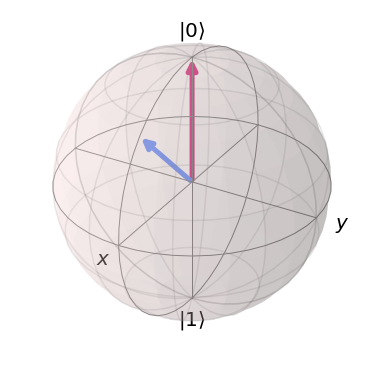

In [6]:
#setting the initial state => rotation of state vector with U_3
plot_bloch_vector([[0,0,1],[1/np.sqrt(2), 0, 1/np.sqrt(2)]])

In [0]:
#setting the initial state 
QC.initial_state(np.pi / 2, 0, 0)

$$
p = 1 \Rightarrow \lambda = 0, \varphi = 0, \theta = \frac{4k-1}{2}\pi=\frac{3}{2}\pi
$$

In [0]:
#setting the parameter of function(p)
QC.parameters(3/2 * np.pi, 0, 0)

In [0]:
#setting number of iteration
QC.number_of_iteration(4)

In [0]:
#build the circuit
QC.build_iteration_circuit()

In [0]:
#adding a measure for the first bit
QC._circuit.measure(0,0)
circuit = QC._circuit

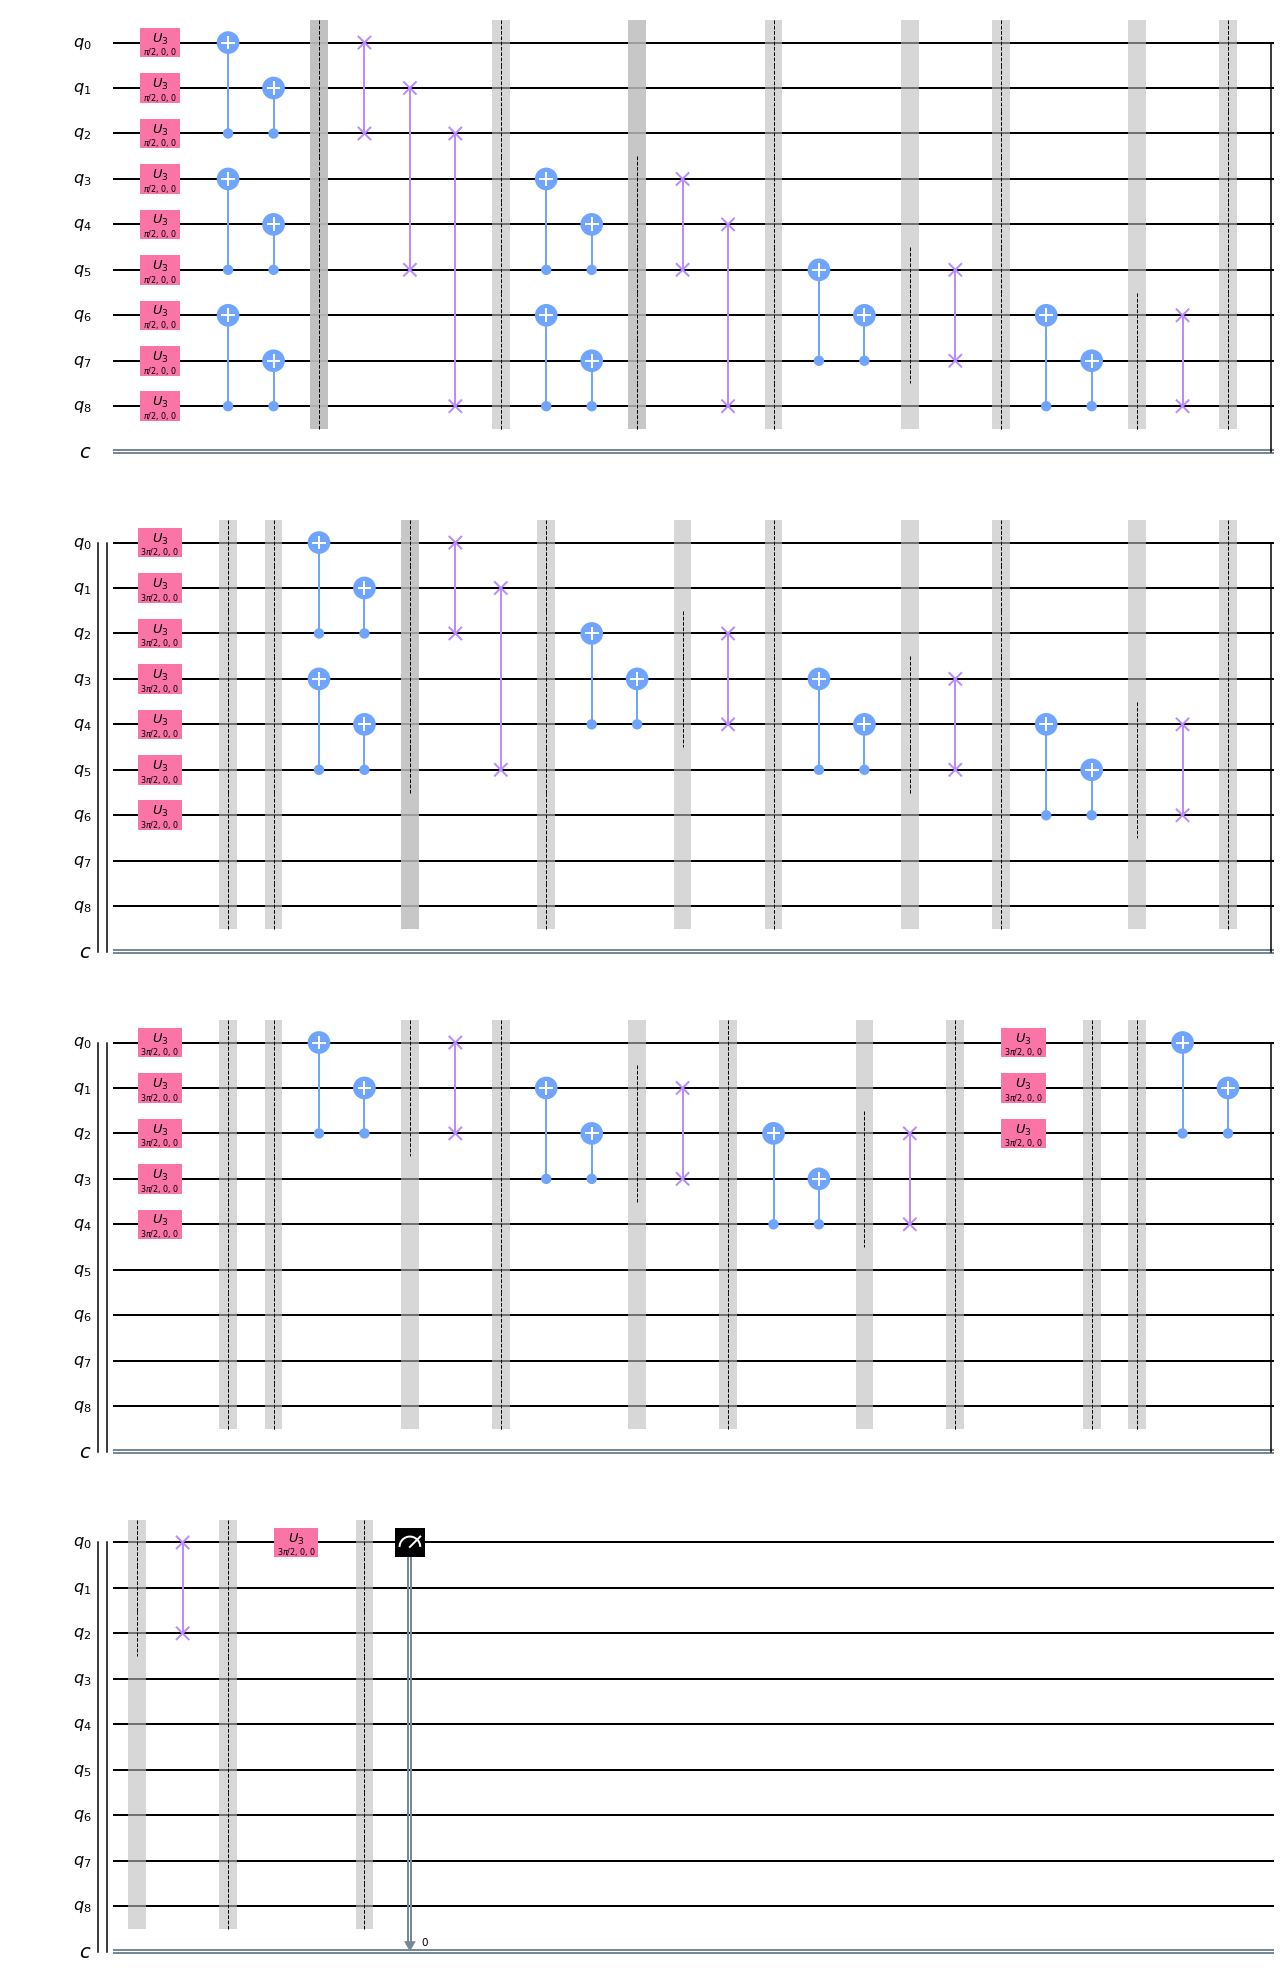

In [12]:
#the plot of circuit
QC.draw_circuit()

In [0]:
#simulation of circuit with qiskit.Aer
EXPERIMENT = execute(circuit, backend, shots = 1000000)

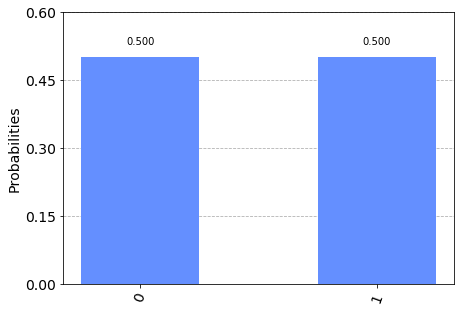

In [14]:
#result of experiment, 4th iteration of f_3,1

result = EXPERIMENT.result()
counts = result.get_counts()
plot_histogram(counts)

In [0]:
#simulating a periodic orbit of function f_3,1

A = [0.5]
for i in range(1,5):
    
    QC = QCIRCUIT(9)
    QC.initial_state(np.pi / 2, 0, 0)
    QC.parameters(3/2 * np.pi, 0, 0)

    QC.number_of_iteration(i)
    QC.build_iteration_circuit()
    QC._circuit.measure(0,0)
    circuit = QC._circuit
    EXPERIMENT = execute(circuit, backend, shots = 1000000)
    result = EXPERIMENT.result()
    counts = result.get_counts()
    A.append(alpha(counts))

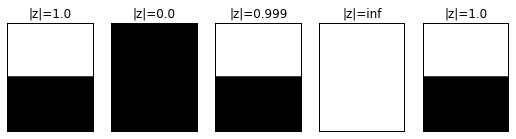

In [16]:
#plotting the result
q_plot(A)

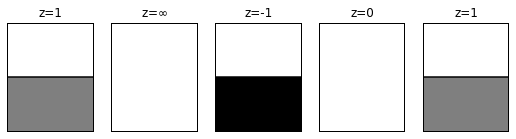

In [17]:
#z = 1 periodic orbit from theoretical calculation
theo_plot()

In [0]:
IBMQ.save_account('d8d9cf72588f5fd1c00709bd5c44a9edb6e633a20197de3a54765059dbdb3678f50cbd842e2be5009e2c52ce8c75d03233c2957ee82b308c3940a14c1b16989b')

In [19]:
#available devices
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [0]:
#select the  15-bit processor
real_device = provider.get_backend('ibmq_16_melbourne')

#the current properties of device
properties = real_device.properties()
coupling_map = real_device.configuration().coupling_map

#using the properties of the device to make a noiss model for simulating
noise_model = NoiseModel.from_backend(properties)

In [0]:
#making circuit for iteration of function, in case d = 3, p = 1
#intial state is N(|0> + |1>) => |z| = 1

QC = QCIRCUIT(9)

QC.initial_state(np.pi / 2, 0, 0)
QC.parameters(3/2 * np.pi, 0, 0)
QC.number_of_iteration(4) # 4th iteral
QC.build_iteration_circuit()
QC._circuit.measure(0,0)

qc = QC._circuit

In [0]:
#simulating the circuit with the noise model

job = execute(qc, backend, shots = 1024, noise_model = noise_model,
                    coupling_map = coupling_map,
                    basis_gates = noise_model.basis_gates)

counts = job.result().get_counts()

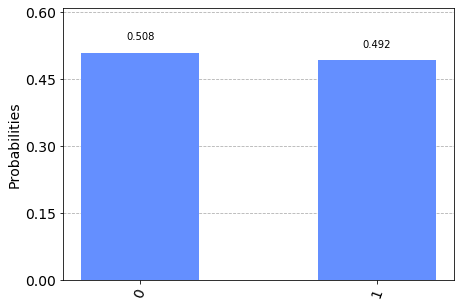

In [23]:
#result of simulation

plot_histogram(counts)

In [0]:
#same simulation of iteration with the noise model
A = [0.5]
C = []
for i in range(1,5):
    
    QC = QCIRCUIT(9)
    QC.initial_state(np.pi / 2, 0, 0)
    QC.parameters(3/2 * np.pi, 0, 0)

    QC.number_of_iteration(i)
    QC.build_iteration_circuit()
    QC._circuit.measure(0,0)
    
    circuit = QC._circuit
    EXPERIMENT = execute(qc, backend, shots = 1000000, noise_model = noise_model,
                    coupling_map = coupling_map)
    
    result = EXPERIMENT.result()
    counts = result.get_counts()
    C.append(counts)
    A.append(alpha(counts))

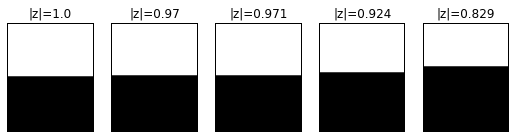

In [29]:
#result of simulation
q_plot(A)

In [30]:
C

[{'0': 514972, '1': 485028},
 {'0': 514500, '1': 485500},
 {'0': 539569, '1': 460431},
 {'0': 592675, '1': 407325}]

In [0]:
#comparison of the simulation and  real device

#creating a circuit for 1 iteration  of f (p = 1, d = 3)
QC = QCIRCUIT(3)

QC.initial_state(np.pi / 2, 0, 0)
QC.parameters(3/2 * np.pi, 0, 0)
QC.number_of_iteration(1)
QC.build_iteration_circuit()
QC._circuit.measure(0,0)

qc = QC._circuit

In [32]:
#devices
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [35]:
#select a device
real_backend = provider.backends()[-4]
print(real_backend)

ibmq_london


In [36]:
shots = 1024
max_credits = 3

job_exp = execute(qc, real_backend, shots = shots, max_credits = max_credits)
job_monitor(job_exp)

Job Status: job has successfully run


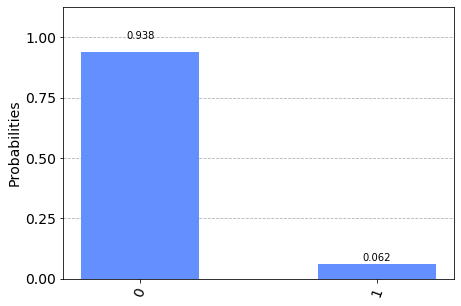

In [37]:
result = job_exp.result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [0]:
sim_backend = Aer.get_backend('qasm_simulator')

In [0]:
#simulation without noise

shots = 1024
job = execute(qc, sim_backend, shots = shots)

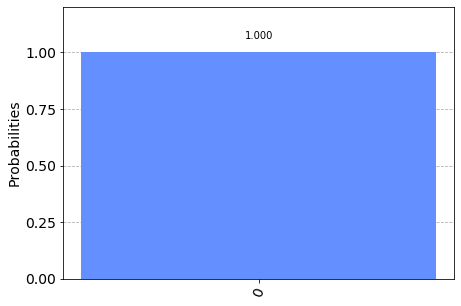

In [40]:
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [0]:
#simulation with noise

properties = real_backend.properties()
noise_model = NoiseModel.from_backend(properties)

shots = 1024
job = execute(qc, sim_backend, shots = 1024, noise_model = noise_model,
                    coupling_map = coupling_map,
                    basis_gates = noise_model.basis_gates)

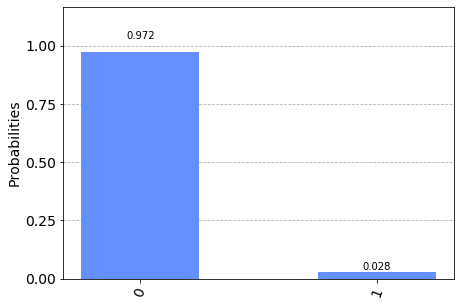

In [42]:
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [79]:
#periodic orbit of function f_3,1 on real device
out = display(progress(0, 4), display_id=True) #progress bar
A = [0.5]

for i in range(1,5):

    progress(i, 4)
    QC = QCIRCUIT(9)
    QC.initial_state(np.pi / 2, 0, 0)
    QC.parameters(3/2 * np.pi, 0, 0)

    QC.number_of_iteration(i)
    QC.build_iteration_circuit()
    QC._circuit.measure(0,0)
    circuit = QC._circuit

    EXPERIMENT = execute(qc, real_device, shots = 1024, max_credits = max_credits)
    result = EXPERIMENT.result()
    counts = result.get_counts()
    A.append(alpha(counts))
    out.update(progress(i, 5))

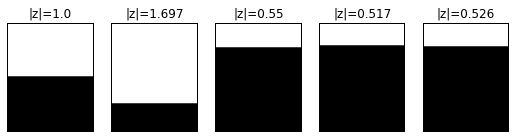

In [80]:
#result
q_plot(A)